In [1]:
import torch
import torch.nn as nn
import PIL.Image
import io
import numpy as np
import datasets
from torchvision.transforms.v2 import CenterCrop, PILToTensor, ToPILImage
from types import SimpleNamespace
from dance import AutoEncoder2D
from walloc.walloc import latent_to_pil, pil_to_latent

In [2]:
device = "cpu"
valid_dataset = datasets.load_dataset("danjacobellis/LSDIR_val", split='validation')
checkpoint = torch.load('../hf/dance/dance_v0.1_rgb_f16c48.pth', map_location=device,weights_only=False)
config = checkpoint['config']
state_dict = checkpoint['state_dict']

model = AutoEncoder2D(
    input_channels=config.input_channels,
    J=int(config.F**0.5),
    latent_dim=config.latent_dim,
    num_res_blocks=config.encoder_depth
).to(device)
model.load_state_dict(state_dict)
model.eval();

6.942 KB
113.28608470181504x compression ratio
16.0x dimension reduction
23.261873741149902 dB PSNR


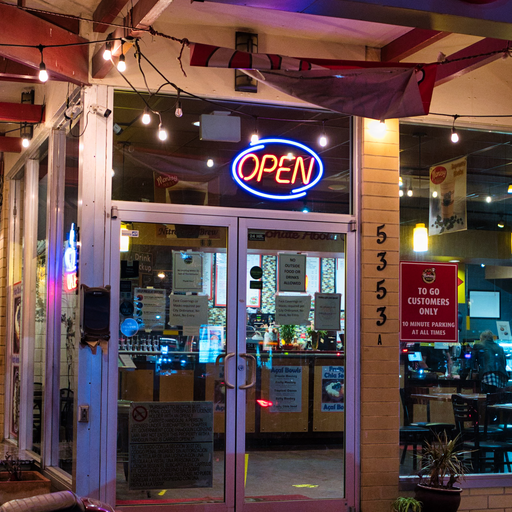

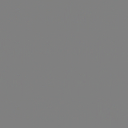

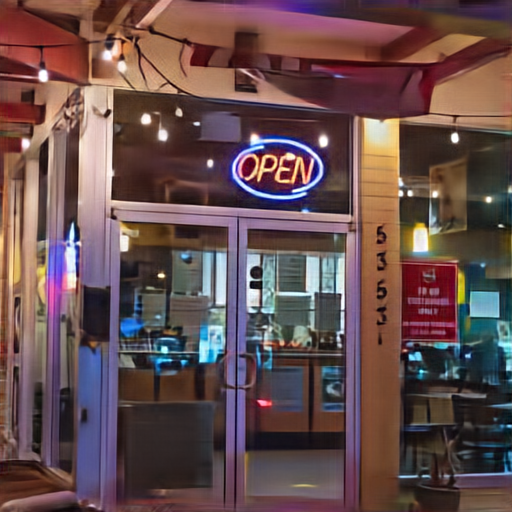

In [3]:
img_size = 512
img = CenterCrop(img_size)(valid_dataset[28]['image'])
x = PILToTensor()(img).to(device).unsqueeze(0).to(torch.float) / 127.5 - 1.0
x_orig = x[0]
orig_dim = x.numel()

with torch.no_grad():
    latent = model.encode(x).clamp(-127.49, 127.49).round()

webp = latent_to_pil(latent.cpu(), n_bits=8, C=3)
buff = io.BytesIO()
webp[0].save(buff, format='WEBP', lossless=True)
size_bytes = len(buff.getbuffer())
print(f"{size_bytes/1e3} KB")
print(f"{orig_dim/size_bytes}x compression ratio")
print(f"{orig_dim/latent.numel()}x dimension reduction")

latent_decoded = pil_to_latent(webp, N=config.latent_dim, n_bits=8, C=3).to(device)

with torch.no_grad():
    x_hat = model.decode(latent_decoded)

mse = torch.nn.functional.mse_loss(x, x_hat)
PSNR = -10 * mse.log10().item() + 6.02
print(f"{PSNR} dB PSNR")

display(ToPILImage()(x_orig.clamp(-1, 1) / 2 + 0.5))  # Original image
display(webp[0])  # Compressed WEBP image
display(ToPILImage()(x_hat[0].clamp(-1, 1) / 2 + 0.5))  # Reconstructed image

23.1170654296875 PSNR
8.0K	test.webp


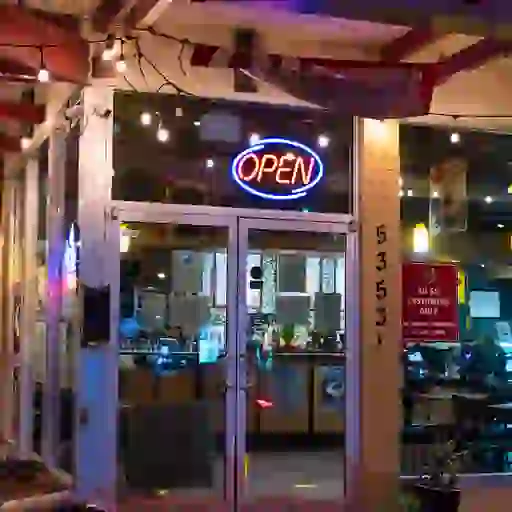

In [4]:
img.crop((0,0,config.img_size,config.img_size)).save("test.webp",quality=0)
webp = PIL.Image.open("test.webp")
MSE = torch.nn.functional.mse_loss(PILToTensor()(webp).to(torch.float)/255, x_orig.to("cpu")/2 + 0.5)
print(f"{-10*MSE.log10()} PSNR")
!du -sh test.webp
display(webp)